# Objectives

To build a Tensorflow based multimodal classifier that consume tabular data with cnt, cat, txt, img columns.

**Features Built**
- [5/5] emb cnt_cols

- [5/5] emb cat_cols

- [5/5] emb txt_cols

- [/5] emb img_cols

- [5/5] automate the separation for cnt, cat, txt columns in df

- [5/5] OneTower structure: concat the emb of txt_cols, cnt_cols, cat_cols for df

- [5/5] allow txt_, cnt_, cat_cols interaction with deep cross module

**Features to Build**

- [/5] trace feature contribution/importance with col_emb_ls

- [/5] tf_clf model based feature selection

- [/5] hyperparameter tuning

- [/5] modularize get_txt_emb_layer(), follow by txt_post_processing such as LSTM, RNN, seq2seq, BERT, https://www.tensorflow.org/text/tutorials/classify_text_with_bert

- [/5] TwoTower structure: concat the emb of txt_cols, cnt_cols, cat_cols for user and item, respectively. It will be useful in a hybrid recommendation system.
 
- [/5] concat emb of cnt + cat + txt + img

**References & Credits**:

- tf cnt+cat: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

- cat + img: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

- cnt + txt: https://towardsdatascience.com/combining-numerical-and-text-features-in-deep-neural-networks-e91f0237eea4

- txt bert https://www.tensorflow.org/text/tutorials/classify_text_with_bert


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: This tutorial is similar to [Classify structured data with feature columns](../structured_data/feature_columns.ipynb). This version uses the [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) instead of the `tf.feature_column` API, as the former are more intuitive and can be easily included inside your model to simplify deployment.

## Import TensorFlow and other libraries


In [2]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 85 kB 4.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers

In [4]:
tf.__version__

'2.7.0'

## Load the dataset and read it into a pandas DataFrame

<a href="https://pandas.pydata.org/" class="external">pandas</a> is a Python library with many helpful utilities for loading and working with structured data. Use `tf.keras.utils.get_file` to download and extract the CSV file with the PetFinder.my mini dataset, and load it into a <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a> with <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html" class="external">`pandas.read_csv`</a>:

In [5]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
df = pd.read_csv(csv_file)

1679360/1668792 [==============================] - 0s 0us/step


Inspect the dataset by checking the first five rows of the DataFrame:

In [6]:
df.tail()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,4
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,3
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,4
11536,Dog,1,Mixed Breed,Male,Brown,No Color,Medium,Short,No,No,Healthy,0,Fili just loves laying around and also loves b...,1,3


## Create a target variable

The original task in Kaggle's <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder.my Adoption Prediction competition</a> was to predict the speed at which a pet will be adopted (e.g. in the first week, the first month, the first three months, and so on).

In this tutorial, you will simplify the task by transforming it into a binary classification problem, where you simply have to predict whether a pet was adopted or not.

After modifying the `AdoptionSpeed` column, `0` will indicate the pet was not adopted, and `1` will indicate it was.

In [7]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
df['target'] = np.where(df['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
df = df.drop(columns=['AdoptionSpeed', ])
df

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,1
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,0


In [8]:
set(df.columns) - set(['target'])

{'Age',
 'Breed1',
 'Color1',
 'Color2',
 'Description',
 'Fee',
 'FurLength',
 'Gender',
 'Health',
 'MaturitySize',
 'PhotoAmt',
 'Sterilized',
 'Type',
 'Vaccinated'}

### Automate the separation of cnt, cat, txt columns

In [9]:
def cnt_cat_txt_split(df, cnt_card=20, dep_var=None, txt_card=0.5):
    """Helper function that returns column names of cnt, cat, txt variables from given df.
    Args: 
      df
      cnt_card (int or float within 0 and 1): cnt cardinarity, e.g. ratio of unique values for cnt column
      dap_var (str default None)
      txt_card (int or float within 0 and 1): txt cardinarity, e.g. ratio of unique values for txt column
    Return:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols) (list of str)
    Example:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols) = cnt_cat_txt_split(df, cnt_card=80, dep_var='target', txt_card=0.5)

    """
    # init placeholder for cnt, cat (int_cat, str_cat), txt
    cnt_cols, cat_cols, txt_cols = [], [], []
    int_cat_cols, str_cat_cols = [], []

    # prep cnt cardinality & txt cardinality
    if cnt_card < 1:
        cnt_card = df.shape[0]*cnt_card
        print(f'cnt_card={cnt_card}')
    if txt_card < 1:
        txt_card = df.shape[0]*txt_card
        print(f'txt_card={txt_card}')
    # exclude target
    cols = set(df.columns) - set([dep_var])

    # separate cnt, cat, txt columns
    for label in cols:
        if ((pd.api.types.is_integer_dtype(df[label].dtype) and
            df[label].unique().shape[0] > cnt_card) or
            pd.api.types.is_float_dtype(df[label].dtype)): #add to cnt_cols
            cnt_cols.append(label)
        elif (pd.api.types.is_string_dtype(df[label].dtype) and
            df[label].unique().shape[0] > txt_card): #add to txt_cols
            txt_cols.append(label)
        else: #add to cat_cols
            cat_cols.append(label)
            if pd.api.types.is_integer_dtype(df[label].dtype): #separate cat_cols into int_cat_cols and str_cat_cols
              int_cat_cols.append(label)
            else:
              str_cat_cols.append(label)
    return txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols)

In [10]:
txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols) = cnt_cat_txt_split(df, cnt_card=80, dep_var='target', txt_card=0.5)
txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols)

txt_card=5768.5


(['Description'],
 ['Age'],
 ['Sterilized',
  'Vaccinated',
  'Breed1',
  'FurLength',
  'Fee',
  'MaturitySize',
  'Gender',
  'Health',
  'PhotoAmt',
  'Color2',
  'Color1',
  'Type'],
 (['Fee', 'PhotoAmt'],
  ['Sterilized',
   'Vaccinated',
   'Breed1',
   'FurLength',
   'MaturitySize',
   'Gender',
   'Health',
   'Color2',
   'Color1',
   'Type']))

In [11]:
len(df['Age'].unique())

105

## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:

In [12]:
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [13]:
print(len(train_df), 'training examples')
print(len(valid_df), 'validation examples')
print(len(test_df), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


## Create an input pipeline using tf.data

Next, create a utility function that converts each training, validation, and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

Note: If you were working with a very large CSV file (so large that it does not fit into memory), you would use the `tf.data` API to read it from disk directly. That is not covered in this tutorial.

In [14]:
def df_to_ds(df, label='target', shuffle=True, batch_size=32):
  """convert pd dataframe to tf.data.Dataset"""
  df = df.copy()
  for col in df.columns:
    if df[[col]].dtypes[col]==np.dtype('O'):
      df[col] = df[col].astype('str')
    if df[[col]].dtypes[col]==np.dtype('int64') or df[[col]].dtypes[col]==np.dtype('float64'):
      df['bin_'+col] = df[col] #will be used for continuous column bucketization
  
  labels = df.pop(label)
  df = {key: value[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Now, use the newly created function (`df_to_ds`) to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable:

**ATTN**: The original df_to_ds() from TF can not process df with txt cols!! Problem solved by converting columns with `object` dtype to `str`

In [15]:
batch_size = 5
train_ds = df_to_ds(train_df,label='target', shuffle=True, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'Description', 'PhotoAmt', 'bin_Age', 'bin_Fee', 'bin_PhotoAmt', 'bin_target']
A batch of ages: tf.Tensor(
[[3]
 [2]
 [2]
 [2]
 [3]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


As the output demonstrates, the training set returns a dictionary of column names (from the DataFrame) that map to column values from rows.

## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

In this tutorial, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf/" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.

You can learn more about the available layers in the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide.

- For _numerical features_ of the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.
- For _categorical features_, such as pet `Type`s (`Dog` and `Cat` strings), you will transform them to multi-hot encoded tensors with `tf.keras.layers.CategoryEncoding`.

### Layer to Normalize Numerical Column

For each numeric feature in the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [17]:
def get_normalization_layer(df:pd.DataFrame, cnt_col:str):
  """get the normalization layer for numberical feature
  Args:
    df: the dataframe containing cnt_col feature
    cnt_col: the name of numeric feature/continuous column
  Return:
   layer: 
  Examples: 
    print(df[['PhotoAmt']].head(5))
    layer = get_normalization_layer(df=df, cnt_col='PhotoAmt')
    layer(df[['PhotoAmt']].head(5))  
  """
  #step0: Prepare a Dataset that only yields the feature.
  df = df.copy()
  for col in df.columns:
    if df[[col]].dtypes[col]==np.dtype('O'):
      df[col] = df[col].astype('str')

  df[cnt_col] = df[cnt_col].astype('float64')
  df_dict = {name: np.array(value) for name, value in df.items()}
  df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
  feature_ds = df_tfds.map(lambda x: x[cnt_col])
  
  #step1: Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)
  
  #step2: Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

Next, test the new function by calling it on the total uploaded pet photo features to normalize `'PhotoAmt'`:

In [18]:
print(df[['PhotoAmt']].head(5))
layer = get_normalization_layer(df=df, cnt_col='PhotoAmt')
layer(df[['PhotoAmt']].head(5))

   PhotoAmt
0         1
1         2
2         7
3         8
4         3


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.8297772 ],
       [-0.5118805 ],
       [ 1.0776026 ],
       [ 1.3954993 ],
       [-0.19398391]], dtype=float32)>

Note: If you have many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single `tf.keras.layers.Normalization` layer.

### Layer to Bucketize Numeric Column


In [19]:
def get_bucketizer_layer(df:pd.DataFrame, cnt_col:str, n_bucket:int=5, embedding_dimension:int=32):
    """To make a cnt_col embedding model that can bucketize each value of cnt_col and turn bucketized value into corresponding embedding vectors
    Args:
        df (pd.DataFrame): 
        cnt_col (str): e.g. 'age', 'timestamp'
        n_bucket (int): e.g. 5
        embedding_dimension (int default 32): embedding vector dimension 
    Returns:
        bucketizer (tf.keras.Sequential())
    References: 
        calpal_tfrs_featureselection_dev04.ipynb
        def cnt_embedding_model(df, user_id, item_id, cnt_col, n_bucket, interactions=None, embedding_dimension=32)

    Examples:
        print(df[['PhotoAmt']].head(5))
        layer = get_bucketizer_layer(df=df, cnt_col='PhotoAmt')
        layer(df[['PhotoAmt']].head(5))
    """
    import keras.backend as K
    from keras.layers import Lambda

    #step0: Prepare a Dataset that only yields the feature.
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')

    df[cnt_col] = df[cnt_col].astype('float64')
    df_dict = {name: np.array(value) for name, value in df.items()}
    df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
    feature_ds = df_tfds.map(lambda x: {cnt_col: x[cnt_col]})
    cnt_col_ls = np.concatenate(list(feature_ds.map(lambda x: x[cnt_col]).batch(100)))

    #step1: prepare a Bucketizer
    max_cnt_col = cnt_col_ls.max()
    min_cnt_col = cnt_col_ls.min()  
    cnt_col_buckets = np.linspace(min_cnt_col, max_cnt_col, num=n_bucket)

    #step2: bucketizer learn from data
    bucketizer = tf.keras.Sequential([
      tf.keras.layers.Discretization(cnt_col_buckets.tolist()),
      tf.keras.layers.Embedding(len(cnt_col_buckets) + 1, embedding_dimension),
    ])
    bucketizer.add(tf.keras.layers.Reshape((-1,embedding_dimension)))
    return bucketizer


In [20]:
list(df['PhotoAmt'].head(5))

[1, 2, 7, 8, 3]

In [21]:
print(df[['PhotoAmt']].head(5))
layer = get_bucketizer_layer(df=df, cnt_col='PhotoAmt', n_bucket=5, embedding_dimension=8)
layer(df[['PhotoAmt']].head(5))

   PhotoAmt
0         1
1         2
2         7
3         8
4         3
0         1
1         2
2         7
3         8
4         3
Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(5, 1, 8), dtype=float32, numpy=
array([[[ 0.03911677,  0.03981615, -0.00105838,  0.00482445,
         -0.03308769, -0.00372886,  0.0033806 ,  0.02088449]],

       [[ 0.03911677,  0.03981615, -0.00105838,  0.00482445,
         -0.03308769, -0.00372886,  0.0033806 ,  0.02088449]],

       [[ 0.03911677,  0.03981615, -0.00105838,  0.00482445,
         -0.03308769, -0.00372886,  0.0033806 ,  0.02088449]],

       [[ 0.04999688,  0.04839465, -0.02878209,  0.00329323,
         -0.03482516,  0.01482899, -0.03704429,  0.03611287]],

       [[ 0.03911677,  0.03981615, -0.00105838,  0.00482445,
         -0.03308769, -0.00372886,  0.0033806 ,  0.02088449]]],
      dtype=float32)>

### Layer to Encode Categorical Column

Pet `Type`s in the dataset are represented as strings—`Dog`s and `Cat`s—which need to be multi-hot encoded before being fed into the model. The `Age` feature 

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [22]:
def get_category_encoding_layer(df:pd.DataFrame, cat_col:str, max_tokens:int=None):
  """get model that can encode categorical column
  Args:
    df: the dataframe containing cat_col feature
    cat_col: the name of categorical feature
    max_token: the number of multi-hot encoding
  Returns:
    layer (tf. model): can be included in the Keras Functional model later.
  Examples:
    print(df[['Age']].head(5))
    test_age_layer = get_category_encoding_layer(df=df, cat_col='Age', max_tokens=5)
    test_age_layer(df[['Age']].head(5))

    print(df[['Type']].head(5))
    test_type_layer = get_category_encoding_layer(df=df, cat_col='Type')
    test_type_layer(df[['Type']].head(5))

  """
  df = df.copy()
  for col in df.columns:
    if df[[col]].dtypes[col]==np.dtype('O'):
      df[col] = df[col].astype('str')
  if df[[cat_col]].dtypes[cat_col]==np.dtype('int64'): #create a layer that turns integer values into integer indices.
    index = layers.IntegerLookup(max_tokens=max_tokens)
    df[cat_col] = df[cat_col].astype('int')
  else: # Create a layer that turns strings into integer indices.
    index = layers.StringLookup(max_tokens=max_tokens)
    df[cat_col] = df[cat_col].astype('str')

  # Prepare a Dataset that only yields the feature.
  df_dict = {name: np.array(value) for name, value in df.items()}
  df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
  feature_ds = df_tfds.map(lambda x: {cat_col: x[cat_col]})
  
  index.adapt(feature_ds.map(lambda x: x[cat_col]))

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  layer = lambda feature: encoder(index(feature))
  return layer

Test the `get_category_encoding_layer` function by calling it on pet `'Type'` features to turn them into multi-hot encoded tensors:

In [23]:
print(df[['Type']].head(5))
test_type_layer = get_category_encoding_layer(df=df, cat_col='Type')
test_type_layer(df[['Type']].head(5))

  Type
0  Cat
1  Cat
2  Dog
3  Dog
4  Dog


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

Repeat the process on the pet `'Age'` features:

In [24]:
print(df[['Age']].head(5))
test_age_layer = get_category_encoding_layer(df=df, cat_col='Age', max_tokens=5)
test_age_layer(df[['Age']].head(5))

   Age
0    3
1    1
2    1
3    4
4    1


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

### Layer to Encode Text Column



In [25]:
def get_text_encoding_layer(df:pd.DataFrame, txt_col:str, max_tokens:int=10000, embedding_dimension:int=32, trainable:bool=True):
    """To make a txt_col embedding model that turn each value of cnt_col into its corresponding embedding vectors
    Args:
        df (pd.DataFrame): e.g. df
        txt_col (str): e.g. 'title', 'description'
        embedding_dimension (int default 32): embedding vector dimension
        trainable (bool default True): to allow (or not) the weights & bias being updated during training
    Returns:
        txt_emb_model (tf.keras.Sequential())

    Example:
        txt_emb_model = get_text_encoding_layer(df, txt_col='description')
        txt_emb_model(['Alex/Paul 1:1', 'Chase/Danielle weekly meeting', 'Elva/Paul biweekly meeting'])
    """
    #step0: prepare data
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')
    df_dict = {name: np.array(value) for name, value in df.items()}
    df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
    feature_ds = df_tfds.map(lambda x: x[txt_col])

    #step1: text tokenization (splitting into constituent words or word-pieces),
    txt_vectorizer = tf.keras.layers.TextVectorization(max_tokens)

    #step2: vocabulary learning
    txt_vectorizer.adapt(feature_ds)

    #step3: embedding.
    txt_emb_model = tf.keras.Sequential([
          txt_vectorizer,
          tf.keras.layers.Embedding(input_dim=len(txt_vectorizer.get_vocabulary()), 
                                    output_dim=embedding_dimension, 
                                    mask_zero=True, #Use masking to handle the variable sequence lengths
                                    trainable=trainable #set trainable=False to prevent the weights from being updated during training
                                    ),

          # We average the embedding of individual words to get one embedding vector per title.
          # tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dimension)),
          tf.keras.layers.Dense(embedding_dimension, activation='relu'),
        ])   
    return txt_emb_model 



In [26]:
print(df[['Description']].head(5))
txt_emb_model = get_text_encoding_layer(df=train_df, txt_col='Description', max_tokens=10000, embedding_dimension=8, trainable=True)
txt_emb_model(df[['Description']].head(5))

                                         Description
0  Nibble is a 3+ month old ball of cuteness. He ...
1  I just found it alone yesterday near my apartm...
2  Their pregnant mother was dumped by her irresp...
3  Good guard dog, very alert, active, obedience ...
4  This handsome yet cute boy is up for adoption....
0  Nibble is a 3+ month old ball of cuteness. He ...
1  I just found it alone yesterday near my apartm...
2  Their pregnant mother was dumped by her irresp...
3  Good guard dog, very alert, active, obedience ...
4  This handsome yet cute boy is up for adoption....
Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01845526, 0.        ],
       [0.        , 0.00319459, 0.00196396, 0.00387777, 0.00253706,
        0.        , 0.        , 0.00477972],
       [0.00570828, 0.00034416, 0.004687  , 0.00290088, 0.00319722,
        0.        , 0.00380845, 0.        ],
       [0.0055737 , 0.00216658, 0.        , 0.        , 0.        ,
        0.        , 0.01106646, 0.        ],
       [0.0100844 , 0.00129083, 0.        , 0.00191838, 0.        ,
        0.        , 0.00301984, 0.        ]], dtype=float32)>

## Preprocess selected features to train the model on

You have learned how to use several types of Keras preprocessing layers. Next, you will:

- Apply the preprocessing utility functions defined earlier on 13 numerical, categorical and text features from the PetFinder.my mini dataset.
- Add all the feature inputs to a list.

As mentioned in the beginning, to train the model, you will use the PetFinder.my mini dataset's text (`'Desciription'`), numerical (`'PhotoAmt'`, `'Fee'`) and categorical (`'Age'`, `'Type'`, `'Color1'`, `'Color2'`, `'Gender'`, `'MaturitySize'`, `'FurLength'`, `'Vaccinated'`, `'Sterilized'`, `'Health'`, `'Breed1'`) features.

Note: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

Earlier, you used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size of 256:

In [27]:
batch_size = 256
train_ds = df_to_ds(train_df, batch_size=batch_size)
val_ds = df_to_ds(valid_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_ds(test_df, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


### processing numerical features

Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called `encoded_features`:

In [28]:
all_inputs = []
encoded_features = []
#cnt_cols = ['PhotoAmt', 'Fee'] # Numerical features.
embedding_dimension= 32

for col in cnt_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=col)
  all_inputs.append(numeric_col)
  normalization_layer = get_normalization_layer(train_df, col)
  encoded_numeric_col = normalization_layer(numeric_col)
  encoded_features.append(encoded_numeric_col)

for col in cnt_cols:
  numeric_col = tf.keras.Input(shape=(1,), name='bin_'+col)
  all_inputs.append(numeric_col)
  bucketizer_layer = get_bucketizer_layer(train_df, col)
  bucketized_numeric_col = tf.reshape(bucketizer_layer(numeric_col), (-1, embedding_dimension))
  # assign new name to tensor
  new_bucketized_numeric_col =  tf.identity(bucketized_numeric_col, name='bin_'+col) #  name='bucketized_'+col
  encoded_features.append(new_bucketized_numeric_col)

In [29]:
#dbck
all_inputs, encoded_features

([<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_Age')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
  <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'tf.identity')>])

### processing categorical features

Turn the integer categorical values from the dataset (the pet age) into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

In [30]:
#int_cat_cols = ['Age']

for col in int_cat_cols:
  int_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='int64')
  encoding_layer = get_category_encoding_layer(
                                               df=train_df,
                                               cat_col=col,
                                               max_tokens=5)
  encoded_int_cat_col = encoding_layer(int_cat_col)
  all_inputs.append(int_cat_col)
  encoded_features.append(encoded_int_cat_col)

Repeat the same step for the string categorical values:

In [31]:
#str_cat_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for col in str_cat_cols:
  str_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
  encoding_layer = get_category_encoding_layer(df=train_df,
                                               cat_col=col,
                                               max_tokens=5)
  encoded_str_cat_col = encoding_layer(str_cat_col)
  all_inputs.append(str_cat_col)
  encoded_features.append(encoded_str_cat_col)

### processing text features

In [32]:
#txt_cols = ['Description']

for col in txt_cols:
  txt_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
  encoding_layer = get_text_encoding_layer(df=train_df,
                                          txt_col=col,
                                          max_tokens=10000,
                                          embedding_dimension=8)
  encoded_txt_col = encoding_layer(txt_col)
  all_inputs.append(txt_col)
  encoded_features.append(encoded_txt_col)

In [33]:
#helper functions
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    """plot history of training and validation on performance metric e.g. accuracy and loss function """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def get_deep_cross_layers(layer_sizes:list=[128, 64, 32], projection_dim:int=32, l1_l2:int=0, alpha:float=1e-4, dropout:float=0.2, flag_cross:bool=True)->tf.keras.Sequential:
    """create deep_cross_layers, which is a tf.keras.Sequential() model
    Args:
        layer_sizes (list of int): e.g. [128, 64, 32]
        projection_dim (int or None): e.g. 32
        l1_l2 (int): choose from {0, 1, 2}, 0: not using l1/l2 regularization, 1: use l1, 2: use l2
        alpha (float): l1 or l2 regularization parameter, usually is a small number e.g. 1e-2
        dropout (float): drop out proportion, usually a small number between 0 and .5.
        flag_cross (bool default True): to use DCN cross or not
    Returns:
        deep_cross_layers (tf.keras.Sequential() model)
    """
    # STEP1: construct the cross layers.
    if flag_cross:
      import tensorflow_recommenders as tfrs
      deep_cross_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                                    kernel_initializer="glorot_uniform", 
                                                                    name='cross_layer'))
    else:
      deep_cross_layers = tf.keras.Sequential()

    # STEP2: construct the deep layers
    # Use the ReLU activation for all but the last layer.
    regu_dict = {0:regularizers.l1(0), 1: regularizers.l1(alpha), 2:regularizers.l2(alpha)}
    for i, layer_size in enumerate(layer_sizes[:-1]):
        deep_cross_layers.add(tf.keras.layers.Dense(layer_size, 
                                                activation="relu",
                                                activity_regularizer=regu_dict[l1_l2],
                                                name=f'{str(i)}_layer')) # to deal with overfitting, use l1 or l2 regularization
        deep_cross_layers.add(Dropout(dropout)) # to deal with overfitting, use dropout

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
        deep_cross_layers.add(tf.keras.layers.Dense(layer_size, name='last_layer'))

    return deep_cross_layers



## Create, compile, and train the model


The next step is to create a model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [34]:
#dbck: expect shape=(None, n) NOT shape=(None, 1, n)
encoded_features, all_inputs

([<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
  <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'tf.identity')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_2')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_4')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_5')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_6')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_8')>,
  <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_9')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_10')>,
  <KerasTensor: shape=(None, 5)

In [35]:
flag_simple = False
if flag_simple:
    # version1: simple
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(all_inputs, output)
else:
    #version2: deepcross
    concat_features = tf.keras.layers.concatenate(encoded_features)

    dc_layers = get_deep_cross_layers(layer_sizes=[64, 32, 1], projection_dim=32, l1_l2=2, alpha=1e-3, dropout=0.5, flag_cross=True)
    output = dc_layers(concat_features)

    #define model accroding to functiional API
    model = tf.keras.Model(inputs=all_inputs, outputs=output)

Configure the model with Keras `Model.compile`:

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

Let's visualize the connectivity graph:


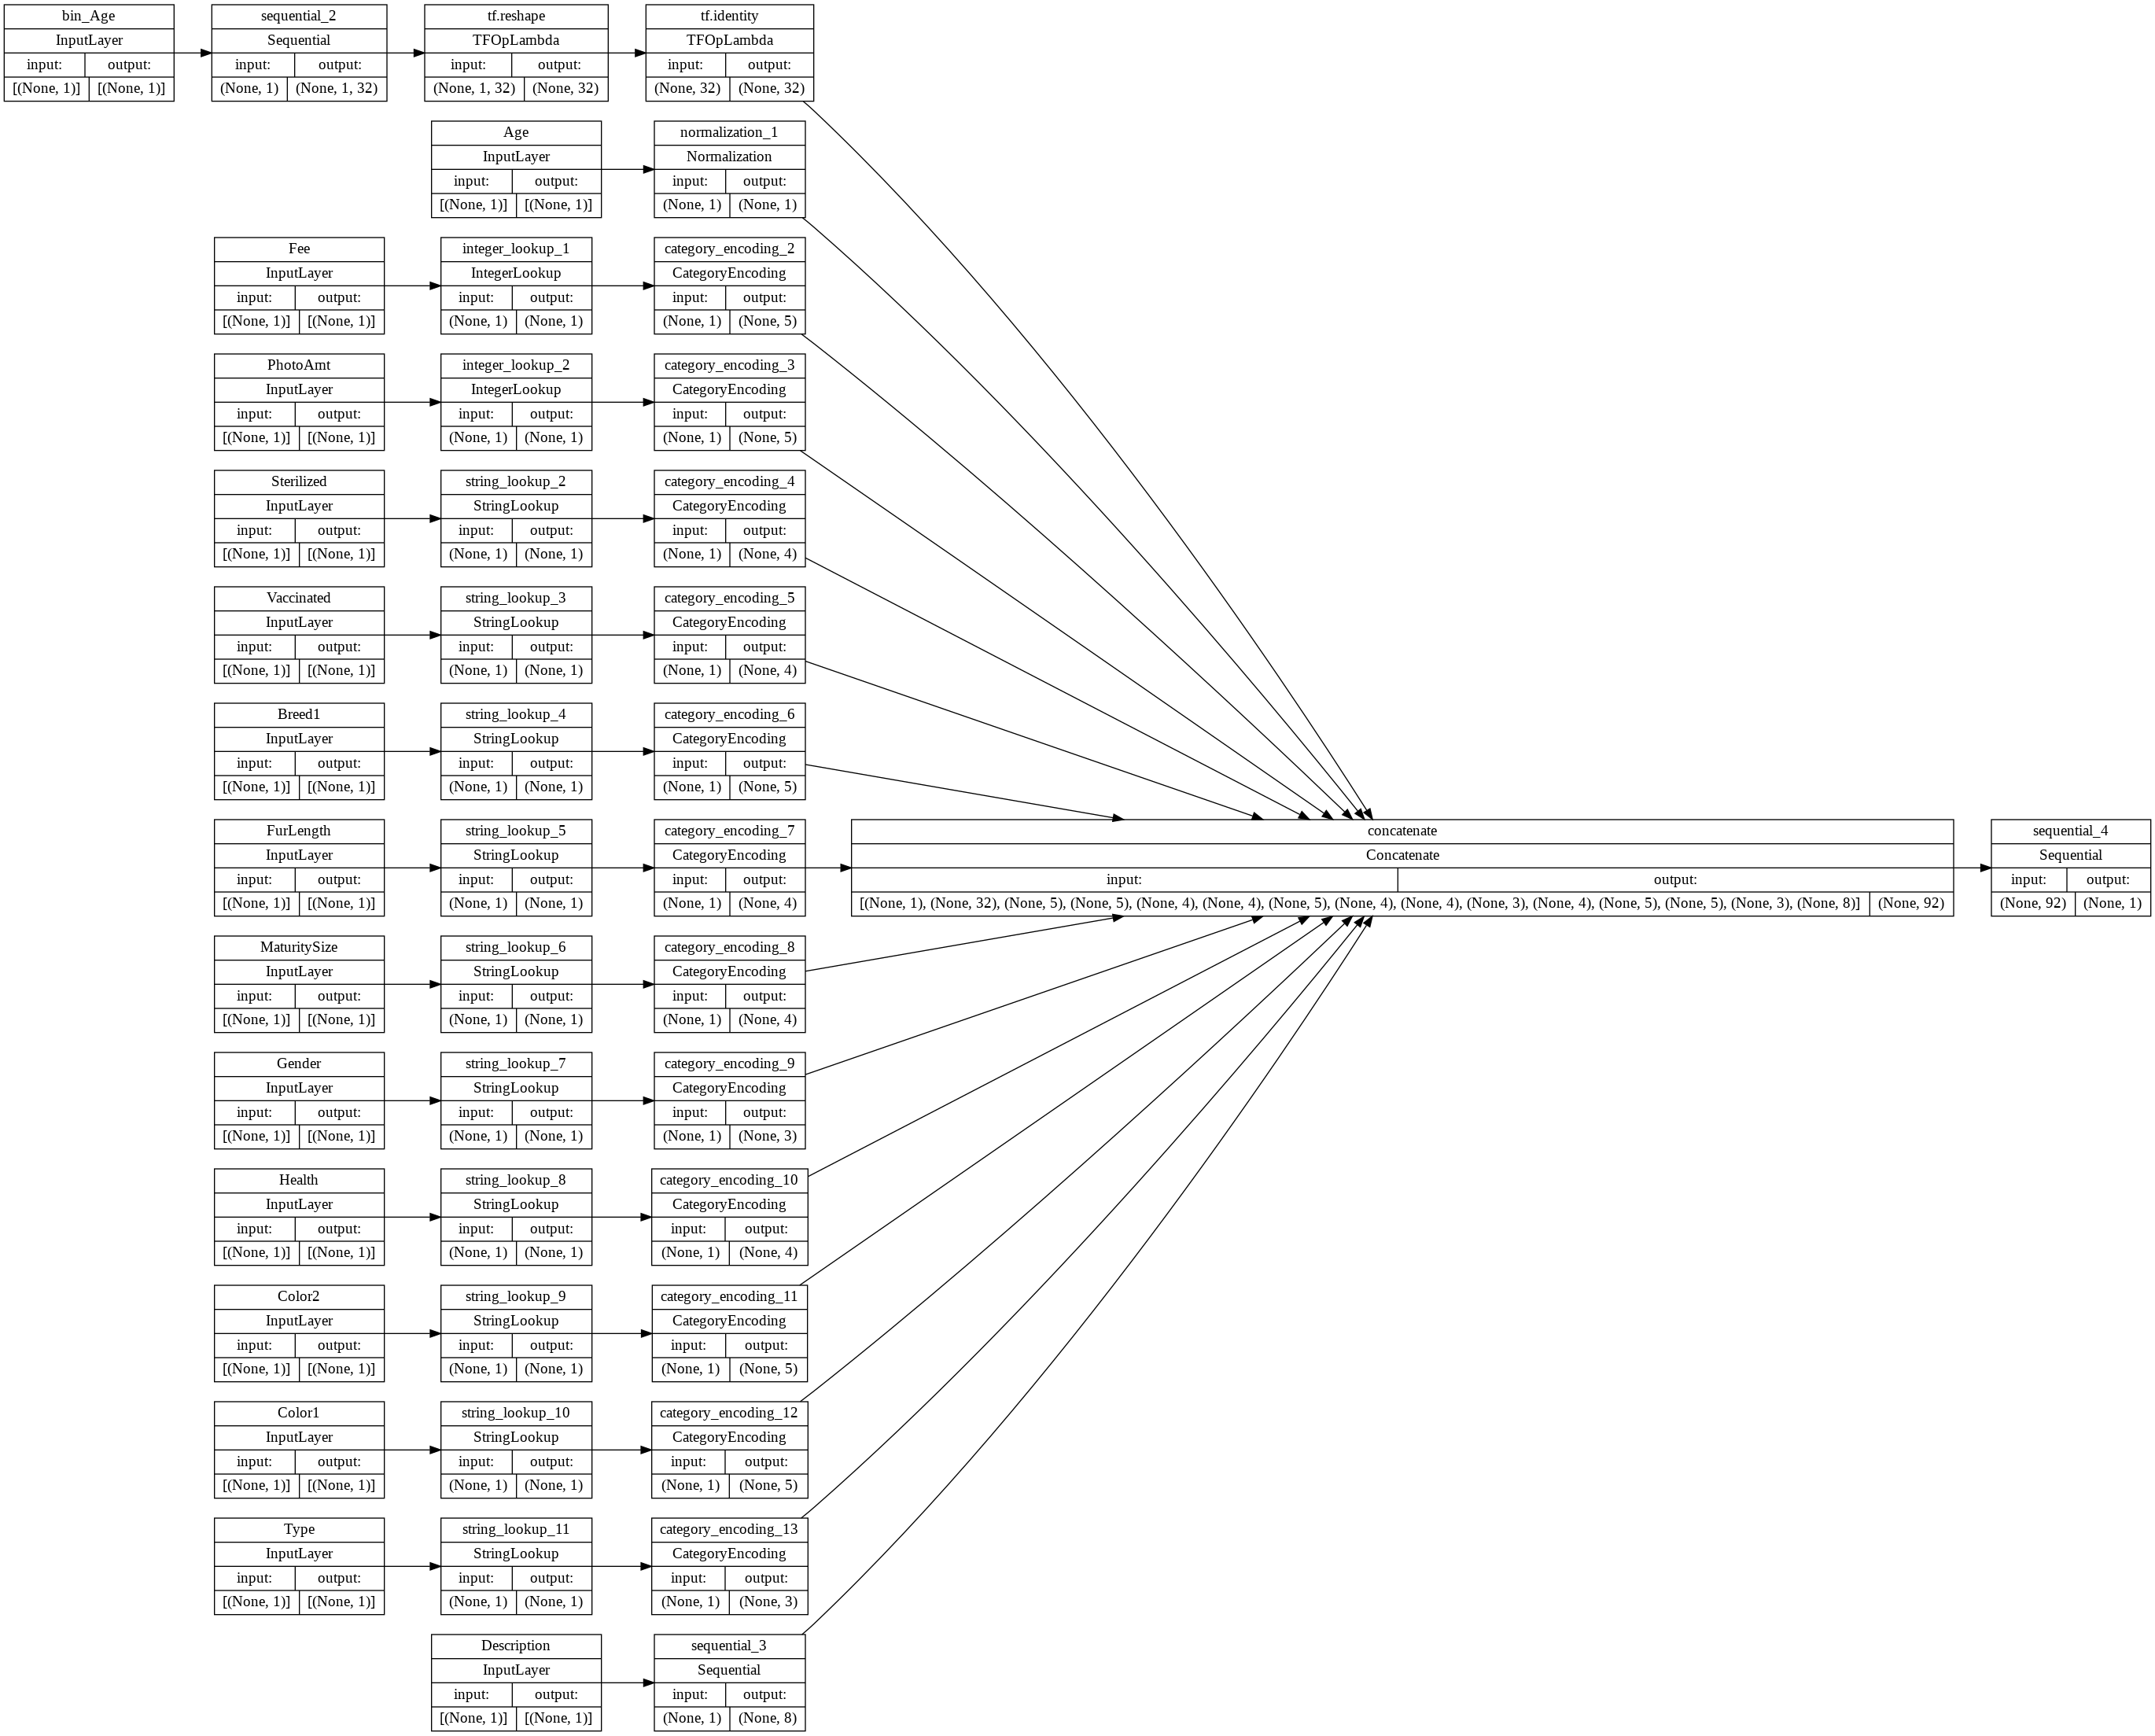

In [37]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next, train and test the model:

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bin_Fee', 'bin_PhotoAmt', 'bin_target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 39s 762ms/step - loss: 0.6101 - accuracy: 0.6230 - val_loss: 0.5674 - val_accuracy: 0.7010
Epoch 2/10
37/37 [==============================] - 26s 664ms/step - loss: 0.5766 - accuracy: 0.6815 - val_loss: 0.5499 - val_accuracy: 0.7201
Epoch 3/10
37/37 [==============================] - 25s 659ms/step - loss: 0.5638 - accuracy: 0.7019 - val_loss: 0.5416 - val_accuracy: 0.7175
Epoch 4/10
37/37 [==============================] - 26s 672ms/step - loss: 0.5456 - accuracy: 0.7043 - val_loss: 0.5241 - val_accuracy: 0.7357
Epoch 5/10
37/37 [==============================] - 26s 664ms/step - loss: 0.4994 - accuracy: 0.7517 - val_loss: 0.5165 - val_accuracy: 0.6976
Epoch 6/10
37/37 [==============================] - 25s 657ms/step - loss: 0.4328 - accuracy: 0.7913 - val_loss: 0.5480 - val_accuracy: 0.7010
Epoch 7/10
37/37 [==============================] - 26s 666ms/step - loss: 0.3616 - accuracy: 0.8469 - val_loss: 0.6078 - val_accuracy: 0.7192
Epoch 8/10

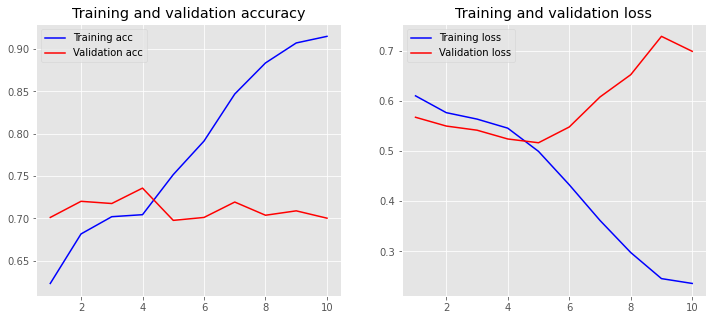

In [38]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)
loss, accuracy = model.evaluate(train_ds, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_ds, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


In [39]:
"""Training Accuracy: 0.9723
Testing Accuracy:  0.7270"""

'Training Accuracy: 0.9723\nTesting Accuracy:  0.7270'

## Perform inference

The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself.

You can now [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before performing inference on new data:

In [40]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


ValueError: ignored

To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).
2.   Call `tf.convert_to_tensor` on each feature.

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
    'Description': 'what a cuty kitty! you cannot help loving him!'
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

Note: You will typically have better results with deep learning with larger and more complex datasets. When working with a small dataset, such as the simplified PetFinder.my one, you can use a <a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">decision tree</a> or a <a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">random forest</a> as a strong baseline. The goal of this tutorial is to demonstrate the mechanics of working with structured data, so you have a starting point when working with your own datasets in the future.


## Next steps

To learn more about classifying structured data, try working with other datasets. To improve accuracy during training and testing your models, think carefully about which features to include in your model and how they should be represented.

Below are some suggestions for datasets:

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): A set of movie ratings from a movie recommendation service.
- [TensorFlow Datasets: Wine Quality](https://www.tensorflow.org/datasets/catalog/wine_quality): Two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. You can also find the Red Wine Quality dataset on <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a>.
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv Dataset</a>: A corpus of 1.7 million scholarly articles from arXiv, covering physics, computer science, math, statistics, electrical engineering, quantitative biology, and economics.


# All Together

In [ ]:
def get_tf_clf(df:pd.DataFrame, label:str='target',txt_cols:list=None, cnt_cols:list=None, int_cat_cols:list=None, str_cat_cols=None, flag_simple_mdl:bool=False):
  """get a deployment ready classifier trained & validated by df (df splitted into train_df, valid_df, test_df)"""
  # split df.columns into txt, cnt, cat which furtherly split into (int_cat, str_cat)
  if txt_cols is None and cnt_cols is None and int_cat_cols is None and str_cat_cols is None:
    txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols) = cnt_cat_txt_split(df, cnt_card=80, dep_var='target', txt_card=0.5)
  
  # split df to train, valid, test model
  train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

  # prep data for tf by converting data from df to ds
  batch_size = 256
  train_ds = df_to_ds(train_df, batch_size=batch_size)
  val_ds = df_to_ds(valid_df, shuffle=False, batch_size=batch_size)
  test_ds = df_to_ds(test_df, shuffle=False, batch_size=batch_size)

  ### prep data for tf clf
  all_inputs = []
  encoded_features = []
  embedding_dimension= 32

  # encode cnt cols by normalization
  for col in cnt_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=col)
    all_inputs.append(numeric_col)
    normalization_layer = get_normalization_layer(train_df, col)
    encoded_numeric_col = normalization_layer(numeric_col)
    encoded_features.append(encoded_numeric_col)

  #encode cnt cols by bucketization
  for col in cnt_cols:
    numeric_col = tf.keras.Input(shape=(1,), name='bin_'+col)
    all_inputs.append(numeric_col)
    bucketizer_layer = get_bucketizer_layer(train_df, col)
    bucketized_numeric_col = tf.reshape(bucketizer_layer(numeric_col), (-1, embedding_dimension))
    # assign new name to tensor
    new_bucketized_numeric_col =  tf.identity(bucketized_numeric_col, name='bin_'+col) #  name='bucketized_'+col
    encoded_features.append(new_bucketized_numeric_col)
  
  # encode integer cat cols
  for col in int_cat_cols:
    int_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='int64')
    encoding_layer = get_category_encoding_layer(
                                                df=train_df,
                                                cat_col=col,
                                                max_tokens=5)
    encoded_int_cat_col = encoding_layer(int_cat_col)
    all_inputs.append(int_cat_col)
    encoded_features.append(encoded_int_cat_col)

  # encode string cat cols
  for col in str_cat_cols:
    str_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
    encoding_layer = get_category_encoding_layer(df=train_df,
                                                cat_col=col,
                                                max_tokens=5)
    encoded_str_cat_col = encoding_layer(str_cat_col)
    all_inputs.append(str_cat_col)
    encoded_features.append(encoded_str_cat_col)

  # encode text cols
  for col in txt_cols:
    txt_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
    encoding_layer = get_text_encoding_layer(df=train_df,
                                            txt_col=col,
                                            max_tokens=10000,
                                            embedding_dimension=8)
    encoded_txt_col = encoding_layer(txt_col)
    all_inputs.append(txt_col)
    encoded_features.append(encoded_txt_col)

  # build classification model 
  #flag_simple_mdl = False
  if flag_simple_mdl:
      # version1: simple
      all_features = tf.keras.layers.concatenate(encoded_features)
      x = tf.keras.layers.Dense(32, activation="relu")(all_features)
      x = tf.keras.layers.Dropout(0.5)(x)
      output = tf.keras.layers.Dense(1)(x)

      model = tf.keras.Model(all_inputs, output)
  else:
      #version2: deepcross
      concat_features = tf.keras.layers.concatenate(encoded_features)

      dc_layers = get_deep_cross_layers(layer_sizes=[64, 32, 1], projection_dim=32, l1_l2=2, alpha=1e-3, dropout=0.5, flag_cross=True)
      output = dc_layers(concat_features)

      #define model accroding to functiional API
      model = tf.keras.Model(inputs=all_inputs, outputs=output)
  if len(df[label].value_counts()) == 2: #binary classification
      model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])
  else:  #multi-class classification
      model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])
  # early stopping to avoid overfitting
  monitor = EarlyStopping(monitor='loss', min_delta=1e-3, 
                        patience=100, verbose=0, mode='auto', restore_best_weights=True)



  history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[monitor],)
  loss, accuracy = model.evaluate(train_ds, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(test_ds, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)
        
  # Use `rankdir='LR'` to make the graph horizontal.
  tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

  # save model
  model.save('my_tf_clf')

  return model
    

In [ ]:
model = get_tf_clf(df, label='target', txt_cols=None, cnt_cols=None, int_cat_cols=None, str_cat_cols=None, flag_simple_mdl=False)




In [ ]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])